Dataset sources:

https://www.kaggle.com/datasets/dschettler8845/brats-2021-task1

In [ ]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt




# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',   
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_SIZE=128
import tarfile
file = tarfile.open('BraTS2021_Training_Data.tar')

file.extractall('./BraTS2021_Training_Data')
file.close()
file = tarfile.open('BraTS2021_00621.tar')

file.extractall('./sample_img')
file.close()

Text(0.5, 1.0, 'Mask')

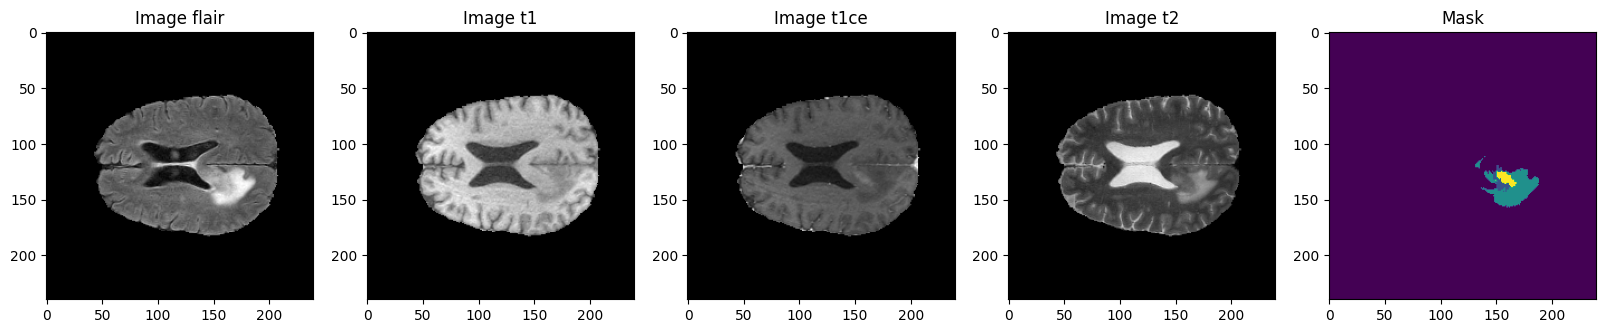

In [4]:
TRAIN_DATASET_PATH = './BraTS2021_Training_Data/'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_flair.nii.gz').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_t1.nii.gz').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_t1ce.nii.gz').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_t2.nii.gz').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_seg.nii.gz').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 30
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

In [46]:
test_image_t2.shape

(240, 240, 155)

In [141]:
torch.unique(torch.from_numpy(test_mask))

tensor([0., 1., 2., 4.], dtype=torch.float64)

In [140]:
test_mask[:,:,test_mask.shape[0]//2-slice_w].shape

(240, 240)

View of Brain Scan over slices

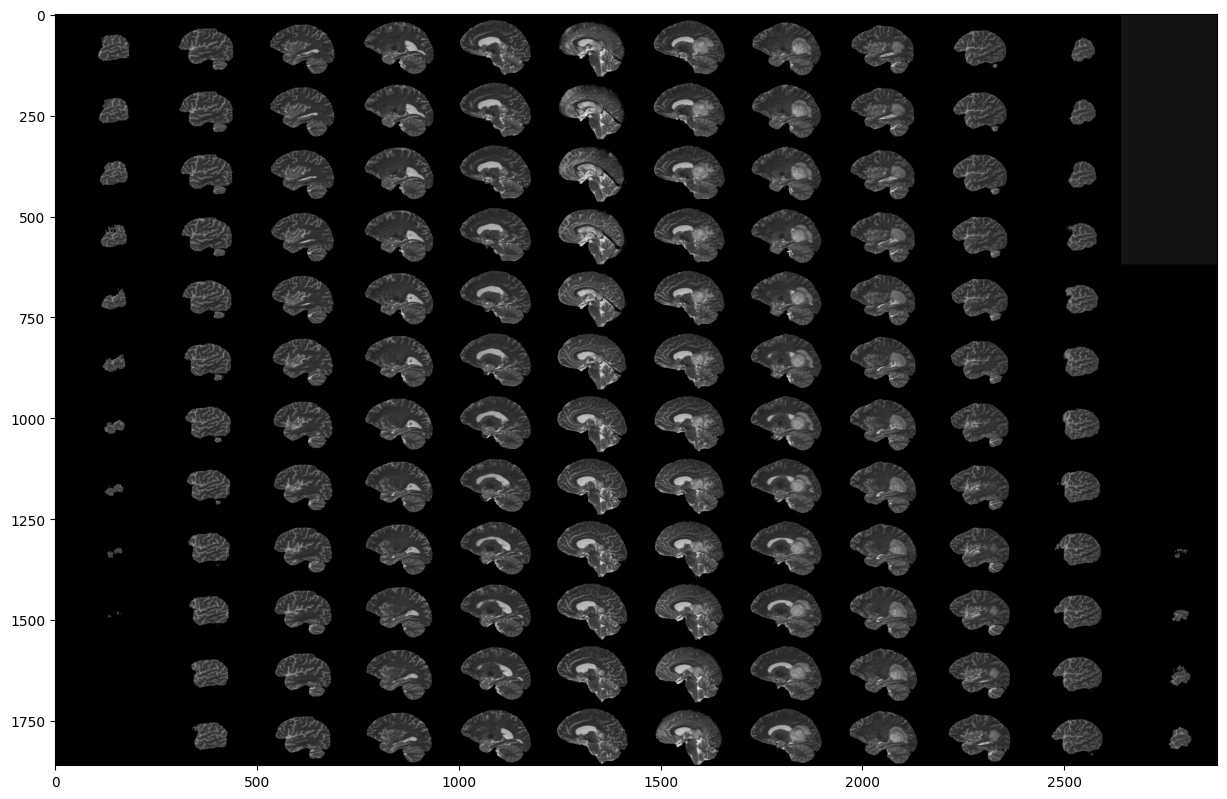

In [5]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t2[50:-50,:,:]), 90, resize=True), cmap ='gray')

View of Masks over Slices

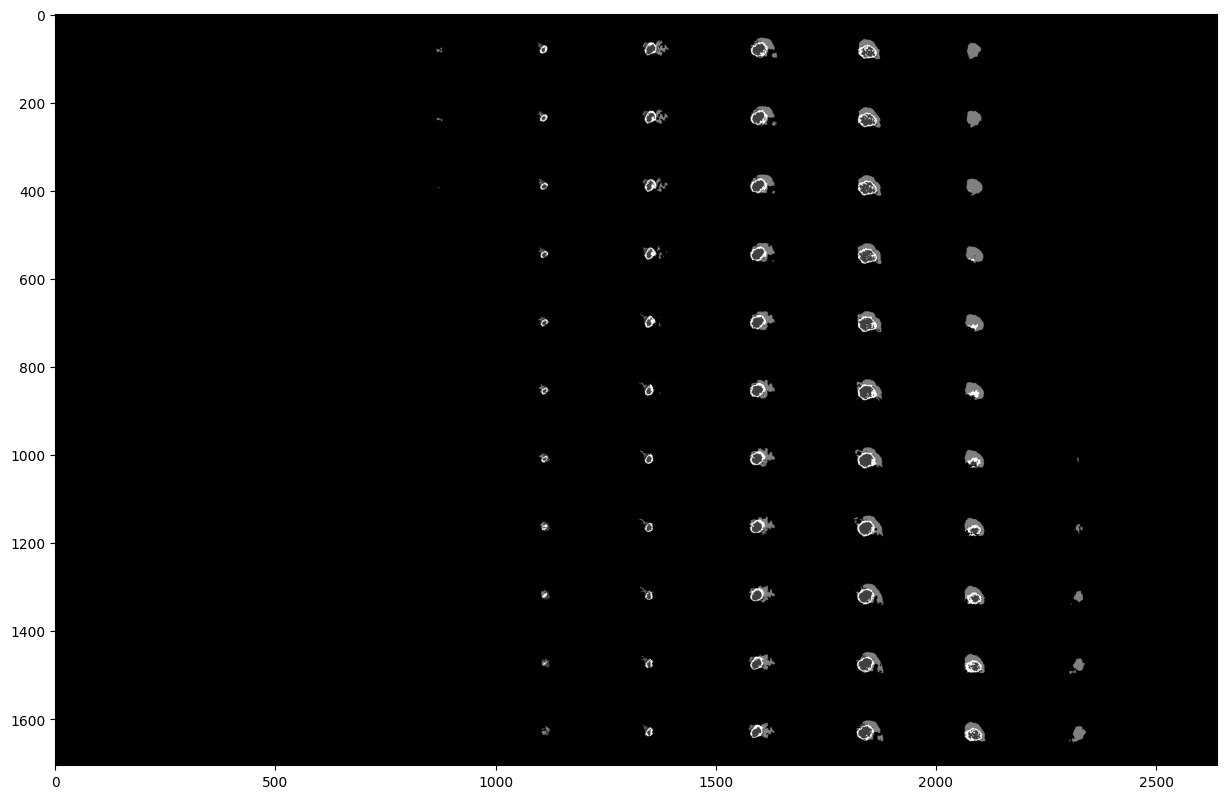

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

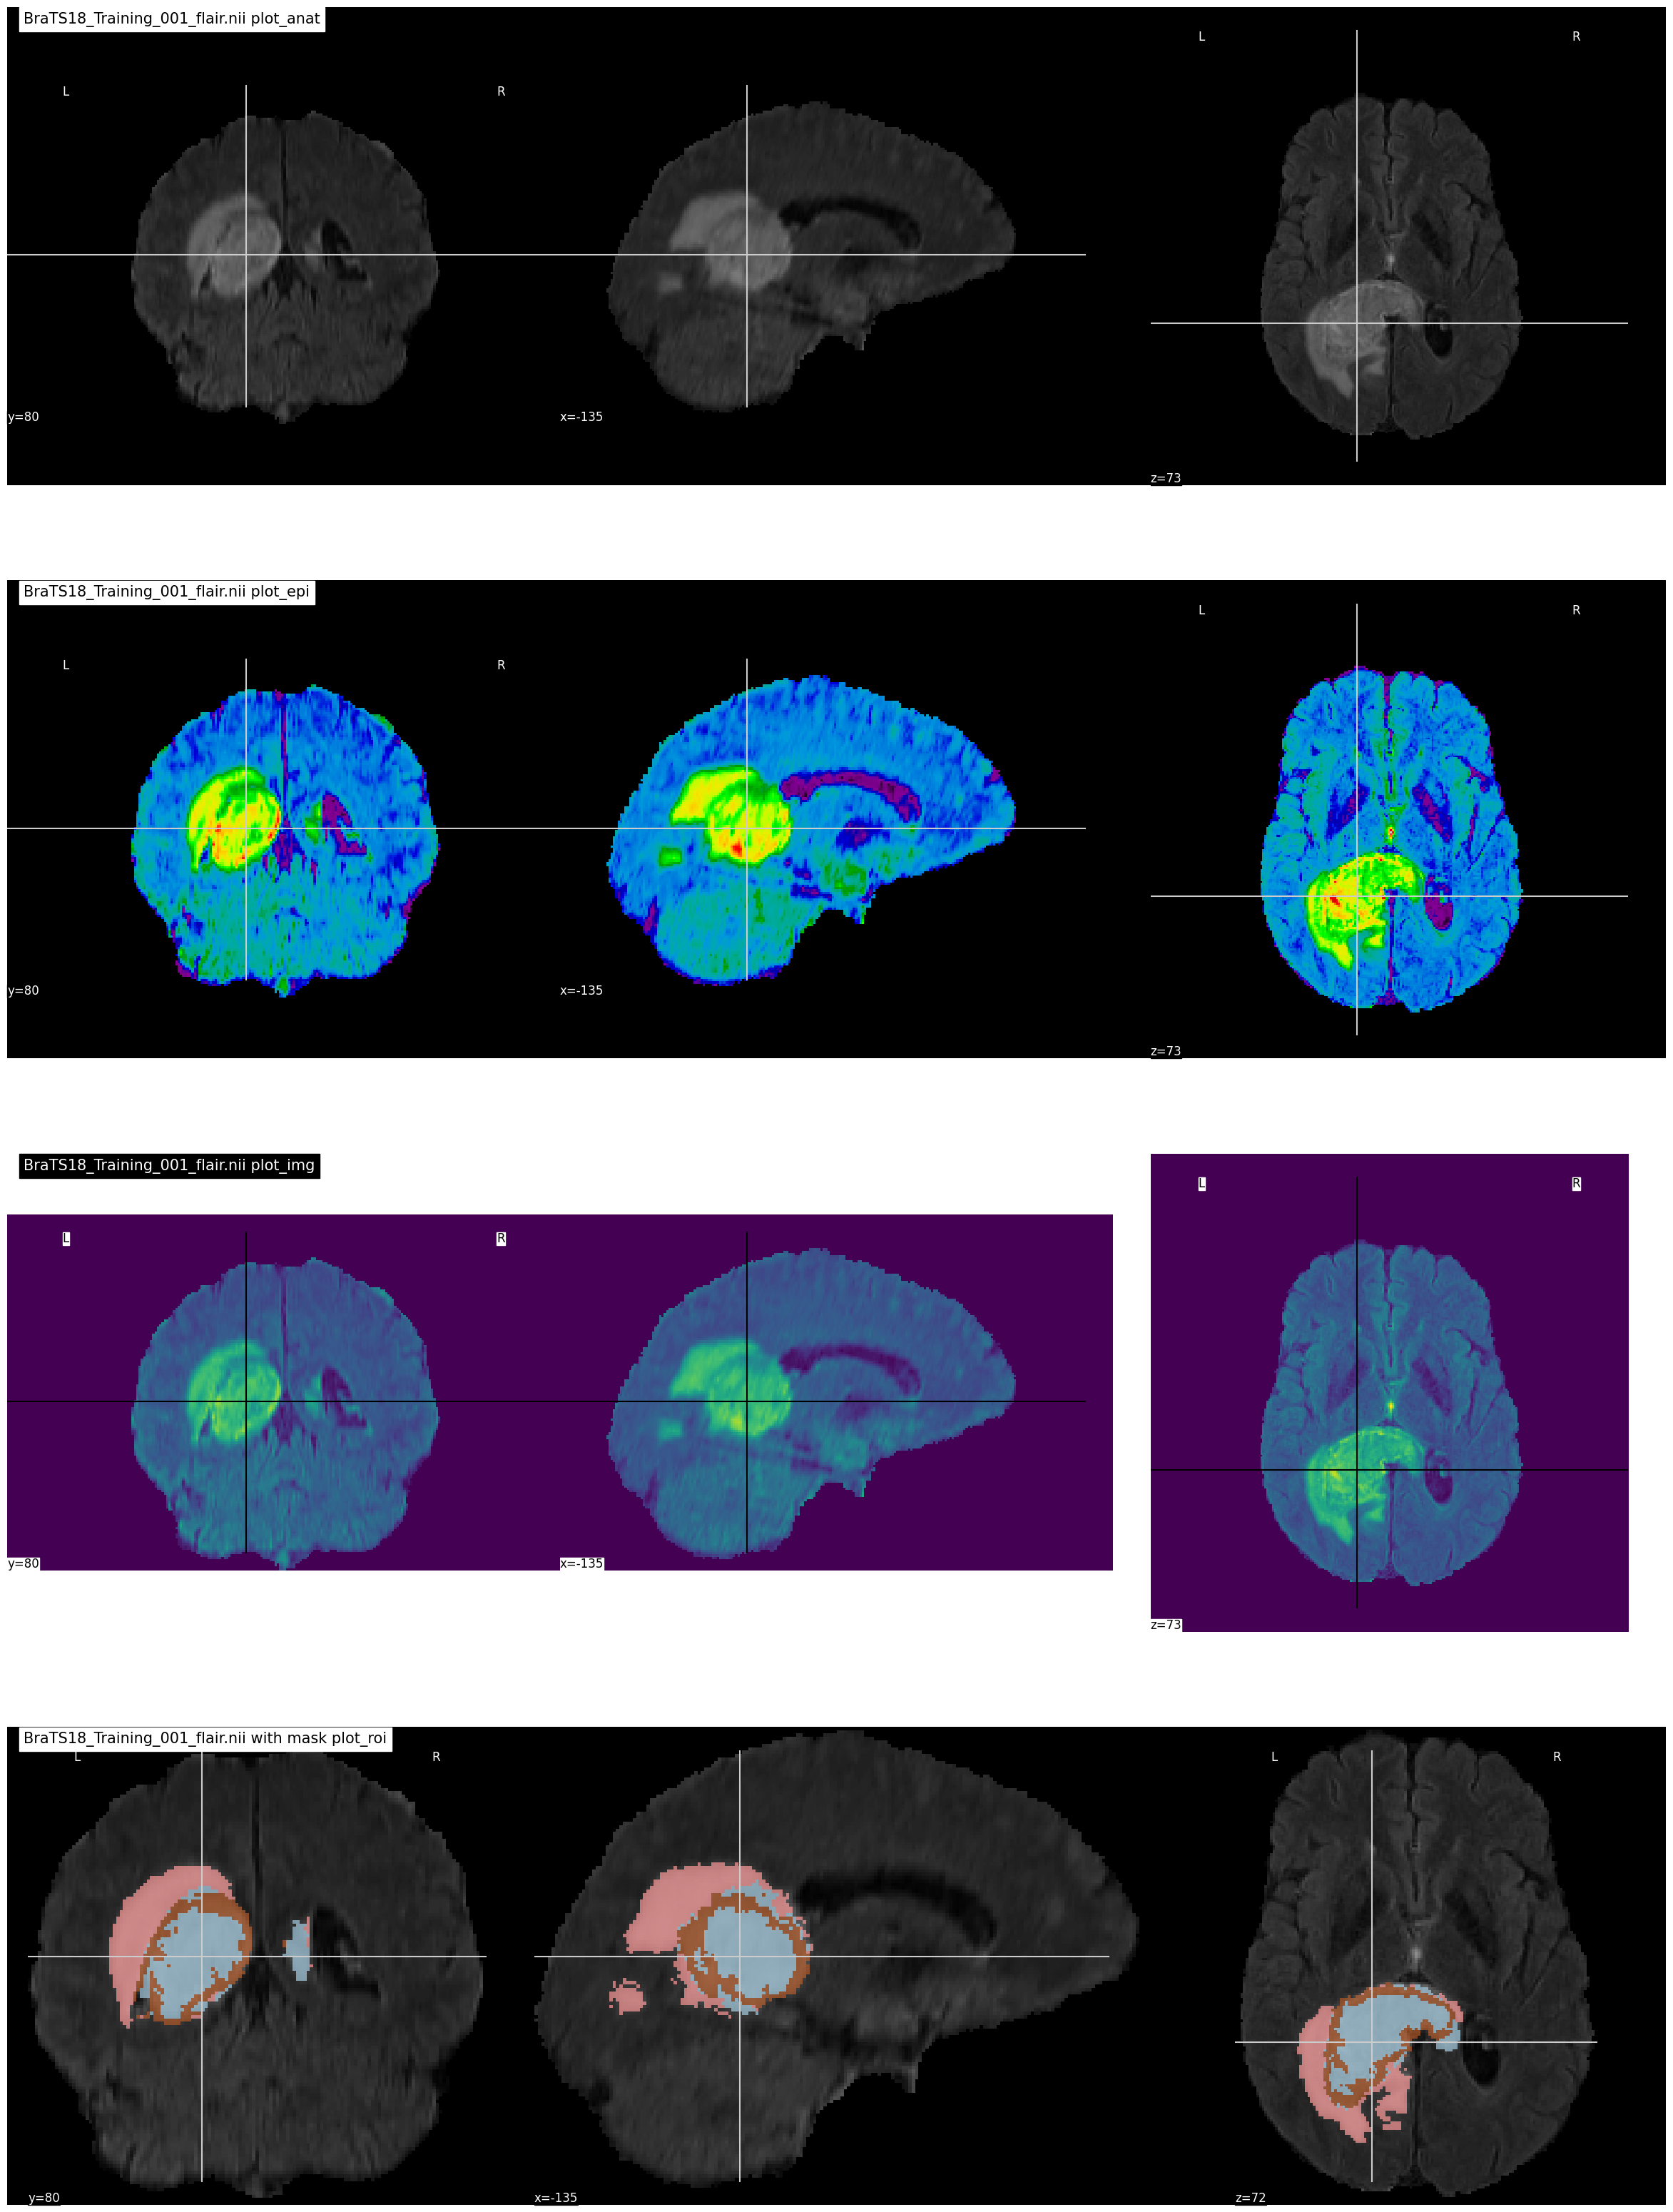

In [7]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_flair.nii.gz')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_seg.nii.gz')



fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS18_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS18_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS18_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS18_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [8]:
import tarfile
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


def extract_task1_files(root="./data"):
    tar = tarfile.open("BraTS2021_Training_Data.tar")
    tar.extractall(root)
    tar.close()


extract_task1_files()

In [15]:
import nibabel as nib
import os
import albumentations as A
import numpy as np


class ImageReader:
    def __init__(self, root:str, img_size:int=256, normalize:bool=False, single_class:bool=False):
        pad_size = 256 if img_size > 256 else 224
        self.resize = A.Compose(
            [
                A.PadIfNeeded(min_height=pad_size, min_width=pad_size, value=0),
                A.Resize(img_size, img_size)
            ]
        )
        self.normalize=normalize
        self.single_class=single_class
        self.root=root


    def read_file(self, path:str) -> dict:
        scan_type = path.split('_')[-1]
        raw_image = nib.load(path).get_fdata()
        raw_mask = nib.load(path.replace(scan_type, 'seg.nii.gz')).get_fdata()
        processed_frames, processed_masks = [], []
        for frame_idx in range(raw_image.shape[2]):
            frame = raw_image[:, :, frame_idx]
            mask = raw_mask[:, :, frame_idx]
            if self.normalize:
                if frame.max() > 0:
                    frame = frame/frame.max()
                frame = frame.astype(np.float32)
            else:
                frame = frame.astype(np.uint8)
            resized = self.resize(image=frame, mask=mask)
            processed_frames.append(resized['image'])
            processed_masks.append(1*(resized['mask'] > 0) if self.single_class else resized['mask'])
        return {
            'scan': np.stack(processed_frames, 0),
            'segmentation': np.stack(processed_masks, 0),
            'orig_shape': raw_image.shape
        }
    
    def load_patient_scan(self, idx:int, scan_type:str='flair') -> dict:
        patient_id = str(idx).zfill(5)
        scan_filename = f'{self.root}/BraTS2021_{patient_id}/BraTS2021_{patient_id}_{scan_type}.nii.gz'
        return self.read_file(scan_filename)



import plotly.graph_objects as go
import numpy as np

 
# generate_3d_scatter(): This is a function that creates a Plotly Scatter3d object for rendering
# three-dimensional data.
# This function accepts parameters such as x, y, z (array of coordinate data), colors (array of colors),
# size (point size), opacity (opacity), scale (color palette), hover (information displayed when
# hover), and name (the name of the Scatter3d object).


def generate_3d_scatter(
    x:np.array, y:np.array, z:np.array, colors:np.array,
    size:int=3, opacity:float=0.2, scale:str='Teal',
    hover:str='skip', name:str='MRI'
) -> go.Scatter3d:
    return go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers', hoverinfo=hover,
        marker = dict(
            size=size, opacity=opacity,
            color=colors, colorscale=scale
        ),
        name=name
    )


class ImageViewer3d():
# The constructor (__init__) of the ImageViewer3d class takes parameters like reader
# (ImageReader object), mri_downsample (reduced sample rate of MRI images),
# and mri_colorscale (color palette for MRI images).
    def __init__(self, reader:ImageReader, mri_downsample:int=10, mri_colorscale:str='Ice', voxel_size:float=0.1) -> None:
        self.reader = reader
        self.mri_downsample = mri_downsample
        self.mri_colorscale = mri_colorscale
        self.voxel_size = voxel_size
        
# The load_clean_mri() method is used to load the MRI image data after cleaning.
# This method takes as input image (numpy array of images) and orig_dim (original size
# belong to image). It calculates the x, y, z coordinates of the points in the MRI image with a greater value
# 0, uses the reduced sample rate mri_downsample, and returns a dictionary containing information about the coordinates
# and color of the points.
    def load_clean_mri(self, image:np.array, orig_dim:int) -> dict:
        shape_offset = image.shape[1]/orig_dim
        z, x, y = (image > 0).nonzero()
        # only (1/mri_downsample) is sampled for the resulting image
        x, y, z = x[::self.mri_downsample], y[::self.mri_downsample], z[::self.mri_downsample]
        colors = image[z, x, y]
        return dict(x=x/shape_offset, y=y/shape_offset, z=z, colors=colors)
    
# The load_tumor_segmentation() method is used to load the tumor segmentation data.
# This method takes as input image (numpy array of segments) and orig_dim (original size
# belong to image). It calculates the x, y, z coordinates of the points in the segment with corresponding values
# for tumor classes, use different reduction sample ratios (1/1, 1/3, 1/5) for each class, and return
# about a dictionary containing information about the coordinates and colors of the points.
    def load_tumor_segmentation(self, image:np.array, orig_dim:int) -> dict:
        tumors = {}
        shape_offset = image.shape[1]/orig_dim
        # 1/1, 1/3 and 1/5 pixels for tumor tissue classes 1(core), 2(invaded) and 4(enhancing)
        sampling = {
            1: 1, 2: 3, 4: 5
        }
        for class_idx in sampling:
            z, x, y = (image == class_idx).nonzero()
            x, y, z = x[::sampling[class_idx]], y[::sampling[class_idx]], z[::sampling[class_idx]]
            tumors[class_idx] = dict(
                x=x/shape_offset, y=y/shape_offset, z=z,
                colors=class_idx/4
            )
        return tumors

    
# The collect_patient_data function in the above code is used to collect data from patients and
# calculate parameters related to the size and distribution of parts in the MRI image.
# First, this function loads clean MRI images (clean_mri) and segmentation information of UT tumor types
# (tumors) from the scan argument. Clean MRI image and segmentation information stored in variables
# clean_mri and tumors respectively.
# Next, the size of a voxel is calculated by taking the third power of the voxel size
# (self.voxel_size). The voxel_volume variable stores the voxel size.
# The markers_created variable is calculated as the sum of the points in the clean MRI image and all the u . segments
# UT project in tumors. This represents the total number of points generated to show the above sections
# 3D image.
# Next, the number of points in each section (clean MRI image, core tumour, invasive surrounding tissue
# by UT project, enhanced UT project) is calculated by taking the size of each data array from
# clean_mri and tumors and use the .shape[0] attribute.
# Then the percentage score for each section is calculated by dividing the score for that section
# for markers_created and multiply by 100. Results are stored in clean_mri_tile variables,
# tumor1_tile, tumor2_tile, and tumor4_tile.
# Next, the size of each section is calculated by multiplying the number of points in that section by
# voxel_volume and stored in variables clean_mri_kichthuoc, tumor1_kichthuoc,
# tumor2_kichthuoc, and tumor4_kichthuoc.
# Then information about the number of points and the size of each part is printed to the screen using
# print statement.
# Finally, the function returns a list containing the corresponding generate_3d_scatter objects
# with sections and number of markers_created. These generate_3d_scatter objects are
# used to display parts on 3D images.
    def collect_patient_data(self, scan:dict) -> tuple:
        clean_mri = self.load_clean_mri(scan['scan'], scan['orig_shape'][0])
        tumors = self.load_tumor_segmentation(scan['segmentation'], scan['orig_shape'][0])
        
        voxel_volume = self.voxel_size ** 3
        markers_created = clean_mri['x'].shape[0] + sum(tumors[class_idx]['x'].shape[0] for class_idx in tumors)
        
        clean_mri_diem = clean_mri['x'].shape[0]
        tumor1_diem = tumors[1]['x'].shape[0]
        tumor2_diem = tumors[2]['x'].shape[0]
        tumor4_diem = tumors[4]['x'].shape[0]
        
        clean_mri_tile = round(clean_mri_diem /markers_created*100, 2)
        tumor1_tile = round(tumor1_diem /markers_created*100, 2)
        tumor2_tile = round(tumor2_diem /markers_created*100, 2)
        tumor4_tile = round(tumor4_diem /markers_created*100, 2)
 
        clean_mri_kichthuoc = str(round(clean_mri_diem * voxel_volume, 2)) + ' cm^3'
        tumor1_kichthuoc = str(round(tumor1_diem * voxel_volume, 2)) + ' cm^3'
        tumor2_kichthuoc = str(round(tumor2_diem * voxel_volume, 2)) + ' cm^3'
        tumor4_kichthuoc = str(round(tumor4_diem * voxel_volume, 2)) + ' cm^3'
        
        print('Brain MRI - clean MRI images:', clean_mri_diem ,'points,', clean_mri_tile ,'%',clean_mri_kichthuoc)
        print('UT core project:', tumor1_diem , 'points,', tumor1_tile ,'%,', tumor1_kichthuoc)
        print('The surrounding tissue is invaded by cancerous tumor: ', tumor2_diem ,'points,', tumor2_tile ,'%', tumor2_kichthuoc)
        print('Cancer cases enhanced with substances containing Gadolinium:', tumor4_diem ,'points,', tumor4_tile,'%,', tumor4_kichthuoc)
        
        return [
            generate_3d_scatter(**clean_mri, scale=self.mri_colorscale, opacity=0.3, hover='skip', name='Brain MRI - clean MRI images('+ clean_mri_kichthuoc +')'),
            generate_3d_scatter(**tumors[1], opacity=0.8, hover='all', name='UT core project(' + tumor1_kichthuoc + ')'),
            generate_3d_scatter(**tumors[2], opacity=0.4, hover='all', name='The surrounding tissue is invaded by the tumour(' + tumor2_kichthuoc + ')'),
            generate_3d_scatter(**tumors[4], opacity=0.4, hover='all', name='Cancer cases enhanced with substances containing Gadolinium(' + tumor4_kichthuoc + ')'),
        ], markers_created
 

# The get_3d_scan() method is used to get three-dimensional data of a patient and create an object
# corresponding Scatter3d chart icon. This method takes arguments like patient_idx
# (patient number), and scan_type (MRI scan type). It uses the method
# load_patient_scan() of the ImageReader class to load image data for a specific patient.
# Then it uses the collect_patient_data() method to collect the image data and
# segment of the patient. Finally, it creates a Scatter3d chart object using
# use Scatter3d objects from collected data and set properties and configurations
# for the Scatter3d chart and returns the chart object.
    def get_3d_scan(self, patient_idx:int, scan_type:str='flair') -> go.Figure:
        scan = self.reader.load_patient_scan(patient_idx, scan_type)
        data, num_markers = self.collect_patient_data(scan)
        fig = go.Figure(data=data)
        fig.update_layout(
            title=f"[Patient id:{patient_idx}] brain MRI scan ({num_markers} points)",
            legend_title="Pixel class (click to enable/disable)",
            font=dict(
                family="Courier New, monospace",
                size=14,
            ),
            margin=dict(
                l=0,r=0,b=0,t=30
            ),
            legend=dict(itemsizing='constant')
        )
        return fig

In [16]:
reader = ImageReader('./data', img_size=128, normalize=True, single_class=False)
viewer = ImageViewer3d(reader, mri_downsample=25)

fig = viewer.get_3d_scan(0, 't1')
plotly.offline.iplot(fig)

Brain MRI - clean MRI images: 17259 points, 72.86 % 17.26 cm^3
UT core project: 3343 points, 14.11 %, 3.34 cm^3
The surrounding tissue is invaded by cancerous tumor:  1228 points, 5.18 % 1.23 cm^3
Cancer cases enhanced with substances containing Gadolinium: 1859 points, 7.85 %, 1.86 cm^3


In [21]:
import os
from sklearn.model_selection import train_test_split
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 


SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 128 
VOLUME_START_AT = 22 # first slice of volume that we will include

In [219]:
import os
import nibabel as nib
import cv2
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


class DataGenerator(Dataset):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.list_IDs) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = torch.arange(len(self.list_IDs))
        if self.shuffle:
            self.indexes = self.indexes[torch.randperm(len(self.indexes))]

    def __data_generation(self, batch_ids):
        X = torch.zeros((self.batch_size * VOLUME_SLICES, self.n_channels, *self.dim))
        y = torch.zeros((self.batch_size * VOLUME_SLICES, *self.dim), dtype=torch.long)
        for c, i in enumerate(batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz')
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz')
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii.gz')
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + (VOLUME_SLICES * c), 0] = torch.from_numpy(
                    cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                )
                X[j + (VOLUME_SLICES * c), 1] = torch.from_numpy(
                    cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                )

                y[j + VOLUME_SLICES * c] = torch.from_numpy(
                    cv2.resize(seg[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                )

        # X = X.permute(0, 3, 1, 2)
        y[y == 4] = 3
        Y= F.one_hot(y, num_classes=4).permute(0, 3, 1, 2)
        # Y = F.interpolate(Y, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)

        # X = X.squeeze(dim=0)
        # Y = Y.squeeze(dim=0)

        # print(X.shape, Y.shape)
        
        return X / torch.max(X), Y

# Assuming you have defined IMG_SIZE, VOLUME_SLICES, VOLUME_START_AT, TRAIN_DATASET_PATH, train_ids, val_ids, and test_ids earlier in your code.
IMG_SIZE = 240
training_dataset = DataGenerator(train_ids, batch_size=1, shuffle=True, dim=(IMG_SIZE, IMG_SIZE))
valid_dataset = DataGenerator(val_ids,batch_size=1, shuffle=True, dim=(IMG_SIZE, IMG_SIZE))
test_dataset = DataGenerator(test_ids, batch_size=1, shuffle=True, dim=(IMG_SIZE, IMG_SIZE))

batch_size = 1  # Adjust as needed
num_workers = 0  # Adjust as needed

training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [220]:
data=next(iter(valid_loader))
in_data=data[0]
out_data=data[1]

print(in_data.shape)
print(out_data.shape)

torch.Size([1, 100, 2, 240, 240])
torch.Size([1, 100, 4, 240, 240])


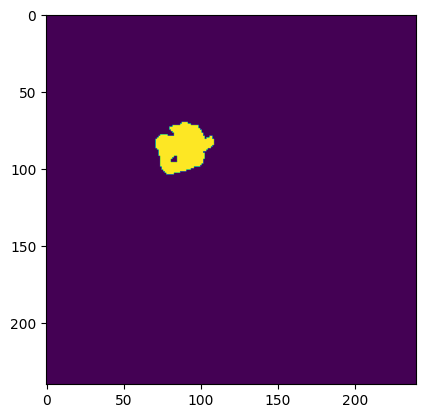

In [221]:
plt.imshow(out_data[0,58,3,:,:])
plt.show()